# Project: Trading Signal Extraction from News Article

Team E: Hanoch Surya Rao Dubbaka, Venkatesh Mudaliar, Muzzammil Siddique, Jinghao Wang

#### ⭐⭐⭐ **PLEASE DON'T TRY TO WRITE/OVERWRITE ANY DATA INTO GOOGLE CLOUD STORAGE.**

For Module 1, this notebook has been tested and `can run from step 1 to 5`. There's `no code` in Module 1 that will trigger write/overwrite function. You can run everything safely.

In [ ]:
from pyspark.sql.functions import input_file_name, regexp_extract, to_date
from pyspark.sql.functions import col, lag, expr, mean, stddev, when, lit, count, split, size, rand
from pyspark.sql.window import Window
import gcsfs
import os

spark = SparkSession.builder.appName("TradingSignal").getOrCreate()

### Tutorial: How to get the access to data

All data has been saved or uploaded to Google Cloud Storage, you can fetch these datasets via their gsurl: `spark.read.csv('gs://tradingsignaldatastorage/notebooks/jupyter/data/<file name>', header=True))`;

or you can go the GS bucket interface and find the gsurl link of each dataset: `https://console.cloud.google.com/storage/browser/tradingsignaldatastorage/notebooks/jupyter/data?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&hl=en&inv=1&invt=Abwehg&project=kinetic-catfish-458421-p3`

## Module 1: Data Preprocessing

All codes in this module were run on GCP. 

FNSPID data includes three files: `All_external.csv (5.3GB)` , `news_article.csv (over 20GB with 90m rows)` , and `full_price.zip (530MB)` .

We'll mainly use `news_article.csv` and `full_price.zip` together with the `SPY500 data` for this project. 


### Step 1: Visualize article data

`Article data` is largest dataset in this project. It contains over `90 million rows`. There're over `7000 tickers` in this dataset. 

In [2]:
article_data = spark.read.csv('gs://tradingsignaldatastorage/notebooks/jupyter/data/news_article_data.csv', header=True).selectExpr(
    "Date as date",
    "Stock_symbol as ticker",
    "Article_title as title",
    "Article as article"
).withColumn('date',to_date('date'))

for col_name in article_data.columns:
    print(f"{col_name}: {article_data.first()[col_name]}")

date: 2023-12-16
ticker: A
title: Interesting A Put And Call Options For August 2024
article: Investors in Agilent Technologies, Inc. (Symbol: A) saw new options begin trading this week, for the August 2024 expiration. One of the key inputs that goes into the price an option buyer is willing to pay, is the time value, so with 241 days until expiration the newly trading contracts represent a possible opportunity for sellers of puts or calls to achieve a higher premium than would be available for the contracts with a closer expiration. At Stock Options Channel, our YieldBoost formula has looked up and down the A options chain for the new August 2024 contracts and identified one put and one call contract of particular interest.


### Step 2: Visualize stock data

`stock_data` is fetched from `full_price.zip`. It contains all the tickers in the `article_data` with over `22 million rows`, but somehow stored in a wrong order. This will be fixed later in step 4. 

In [3]:
stock_data = spark.read.option('header','true').csv("gs://tradingsignaldatastorage/notebooks/jupyter/data/stock_data.csv")
stock_data.limit(5).show(5)

+----------+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+------+
|      date| volume|             open|              high|               low|             close|         adj close|                path|ticker|
+----------+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+------+
|2023-12-28|5703600|30.14999961853028|30.239999771118164|29.950000762939453| 30.18000030517578| 30.18000030517578|gs://tradingsigna...|   HPQ|
|2023-12-27|5127900|30.39999961853028|30.520000457763672|30.209999084472656|30.239999771118164|30.239999771118164|gs://tradingsigna...|   HPQ|
|2023-12-26|4853600|30.13999938964844|30.549999237060547|30.059999465942383| 30.40999984741211| 30.40999984741211|gs://tradingsigna...|   HPQ|
|2023-12-22|4476400|30.21999931335449|30.479999542236328| 30.06999969482422| 30.18000030517578| 30.18000030517578|gs://tradingsigna...|   HPQ|

### Step 3: Visualize spy data

`spy_data` collects spy500 data `from 1999-1-4 to 2023-12-31`. It has over `6000 rows`. 

In [4]:
spy_data = spark.read.option('header','true').csv("gs://tradingsignaldatastorage/notebooks/jupyter/data/spy_data.csv")
spy_data.show()

+----------+---------+--------------------+----------+
|      date|    close|          spy_return|spy_volume|
+----------+---------+--------------------+----------+
|1999-01-04|123.03125|                NULL| 9450400.0|
|1999-01-05| 124.4375| 0.01143002286004572| 8031000.0|
|1999-01-06| 127.4375|0.024108488196885988| 7737700.0|
|1999-01-07| 126.8125|-0.00490436488474...| 5504900.0|
|1999-01-08|   127.75|0.007392804337111878| 6224400.0|
|1999-01-11|126.53125|-0.00954011741682...| 7578300.0|
|1999-01-12|   124.25|-0.01802914299827118| 7768800.0|
|1999-01-13|  123.375|-0.00704225352112...| 1.08106E7|
|1999-01-14|121.21875|-0.01747720364741...| 1.14007E7|
|1999-01-15|  124.375|0.026037638566640885| 7817700.0|
|1999-01-19| 125.1875|0.006532663316582915| 6535100.0|
|1999-01-20| 126.1875| 0.00798801797304044| 6534400.0|
|1999-01-21|122.84375|-0.02649826646854...| 6937500.0|
|1999-01-22| 122.5625|-0.00228949376748...| 7522300.0|
|1999-01-25| 123.8125|0.010198878123406425| 5700300.0|
|1999-01-2

### *Recommend to run scale test from step 4 to 5*

For `scale up test`: You need to split `article_data`, `stock_data` into 5 partitions, then use 20%, 40%, 60%, 80%, 100% of the data to run the code in step 4. 

For `scale out test`: Use full dataset, change worker nodes and test how computation time changes. ** Please ask chatgpt how to change worker nodes **

To get running time, use code:

import time\
start_time = time.time()\
end_time = time.time()\
elapsed_time = end_time - start_time\
print(f"Computation time: {elapsed_time:.6f} seconds")

### Step 4: Calculate financial metrics

For each stock, we'll compute all the following financial metrics, which are return as `return`, 5-day return as `return_5d`, 10-day volatility as `volatility_10d`, 10-day average volume as `avg_volume_10d`, `volume_spike_ratio`, daily excess return over spy500 as `excess_return`, 10-day tracking error over spy500 as `tracking_error` and information ratio over spy500 as `info_ratio`. 

We use `info_ratio` to generate label:
1. An `info_ratio` over 0.5 is considered a positive signal, showing that this stock performs better than spy but also aligns with spy. 
2. An `info_ratio` of 0-0.5 is considered a neutral signal, showing that this stock has a better performance than spy but does not exceed spy too much, or deviates from spy a lot. 
3. An `info_ratio` below -0 is considered a negative signal, showing that this stock performs worse than spy. 

In [6]:
spy_data = spark.read.option('header','true').csv("gs://tradingsignaldatastorage/notebooks/jupyter/data/spy_data.csv")
stock_data = spark.read.option('header','true').csv("gs://tradingsignaldatastorage/notebooks/jupyter/data/stock_data.csv")

# --- 1. Intialize metric dataframe
metric_data = stock_data.withColumn("date", col("date").cast("date")) \
                        .withColumn("close", col("close").cast("double")) \
                        .withColumn("volume", col("volume").cast("double"))

# --- 2. Compute 1-day return ---
w_ticker = Window.partitionBy("ticker").orderBy("date")
metric_data = metric_data.withColumn("return", 
    (col("close") - lag("close", 1).over(w_ticker)) / lag("close", 1).over(w_ticker)
)

# --- 3. Compute 5-day return ---
metric_data = metric_data.withColumn("return_5d",
    (col("close") - lag("close", 5).over(w_ticker)) / lag("close", 5).over(w_ticker)
)

# --- 4. 10-day volatility of daily returns ---
win_10 = w_ticker.rowsBetween(-9, 0)
metric_data = metric_data.withColumn("volatility_10d",
    when(count("return").over(win_10) >= 10, stddev("return").over(win_10))
)

# --- 5. 10-day average volume ---
metric_data = metric_data.withColumn("avg_volume_10d",
    when(count("volume").over(win_10) >= 10, mean("volume").over(win_10))
)

# --- 6. Volume spike ratio: today's volume / avg_volume_10d ---
metric_data = metric_data.withColumn("volume_spike_ratio", 
    when(col("avg_volume_10d").isNotNull(), col("volume") / col("avg_volume_10d"))
)

# --- 7. Join with SPY data ---
metric_data = metric_data.join(spy_data, on="date", how="inner")

# --- 8. Excess return ---
metric_data = metric_data.withColumn("excess_return", col("return") - col("spy_return"))

# --- 9. Tracking error over 10 days ---
metric_data = metric_data.withColumn("tracking_error",
    when(count("excess_return").over(win_10) >= 10, stddev("excess_return").over(win_10))
)

# --- 10. Information Ratio = daily excess return / tracking error ---
metric_data = metric_data.withColumn("info_ratio", col("excess_return") / col("tracking_error"))

# --- 11. Label based on info ratio ---
metric_data = metric_data.withColumn("label", when(col("info_ratio") > 0.5, "positive")
                             .when(col("info_ratio") > 0, "neutral")
                             .otherwise("negative"))

# --- 12. Final selection ---
metric_data = metric_data.select(
    "date", "ticker", "return", "spy_return", "excess_return","tracking_error", 
    "info_ratio", "label", "return_5d", "volatility_10d", 
"volume", "avg_volume_10d", "volume_spike_ratio" 
).na.drop(subset=["info_ratio"])

# --- 13. Make sure order is correct ---
metric_data = metric_data.orderBy(col("ticker").asc(), col("date").asc())

metric_data.limit(5).show()

+----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+-------------------+--------------------+---------+--------------+------------------+
|      date|ticker|              return|          spy_return|       excess_return|      tracking_error|          info_ratio|   label|          return_5d|      volatility_10d|   volume|avg_volume_10d|volume_spike_ratio|
+----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+-------------------+--------------------+---------+--------------+------------------+
|1999-12-03|     A|0.008498632529682797| 0.01836283185840708|-0.00986419932872...|  0.0510894426840919|-0.19307705879116535|negative|0.08042491625250414| 0.05316891340318574|3041600.0|     5181350.0|0.5870284771343376|
|1999-12-06|     A| 0.02808988831371628|-0.00738648707364...|  0.0354763753873639|0.042657193499264154|  0.8316621999048268|

### Step 5: Merge metric data with article data (rows with null artical are dropped)

Around 50% of rows are null in 'article'. We drop these rows to only keep those with article data.

Finally, we got a dataset with `1416463 rows`, called `all_features_data`. 

In [ ]:
# Inner join two dataframes on ticker, then date. 
all_features_data = article_data.drop("volume").join(metric_data, on=["ticker", "date"], how="inner").na.drop(subset=["article"])
all_features_data.limit(10).show()

## Module 2: Generate labels

Multiple attempsts were made to deploy Module 2 on GCP; however due to insufficient memory of master node, training/inference process can't be finished. As a result, we ran the following code on personal computer.

Data are still stored in GCP bucket.

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support
from datasets import Dataset, load_dataset
import pandas as pd
import transformers
import torch
import csv

C:\Users\Admin\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1. Import data

The `10K_all_features` dataset has 10K rows randomly selected from `all_features_data`. 

In [4]:
all_features = pd.read_csv(r"C:\Users\Admin\Desktop\project\10K_all_features.csv")
#access from GCP bucket: gs://tradingsignaldatastorage/notebooks/jupyter/data/10k_all_features.csv
all_features.head()

,ticker,date,title,article,return,spy_return,excess_return,tracking_error,info_ratio,label,return_5d,volatility_10d,volume,avg_volume_10d,volume_spike_ratio
0,CALM,2019-09-30,Cal-Maine Foods Q1 Results Miss Estimates - Qu...,"(RTTNews) - Cal-Maine Foods, Inc. (CALM) repor...",-0.120211,0.004638,-0.124849,0.042622,-2.929203,negative,-0.118465,0.040690,4.160000e+01,4.474000e+01,0.929817
1,PBR-A,2023-12-13,Why the Market Dipped But Super Micro Computer...,Super Micro Computer (SMCI) closed at $300.11 ...,0.024854,0.013790,0.011064,0.016826,0.657527,positive,0.024854,0.020356,5.447200e+06,8.355940e+06,0.651896
2,PFG,2016-07-05,9 Best Stocks to Invest in the Aging Population,"""One of the world's most precious and sought-a...",-0.040117,-0.007193,-0.032924,0.026181,-1.257553,negative,0.035134,0.042362,2.889800e+06,2.257230e+06,1.280242
3,PXD,2014-06-25,Sector Update: Energy,"Energy stocks were mostly higher Wednesday, wi...",0.051523,0.004520,0.047003,0.021782,2.157921,positive,0.020000,0.024319,3.201500e+06,1.454910e+06,2.200480
4,CNA,2018-02-16,Progressive's January Earnings Improve on High...,The Progressive CorporationPGR reported earnin...,0.004874,0.000293,0.004581,0.015415,0.297196,neutral,0.089431,0.028558,1.681000e+05,3.928500e+05,0.427899


### Step 2. Use Finbert to generate label

`FinBERT` (110 million parameters) is a BERT-based language model pre-trained on large-scale financial texts. Unlike general-purpose sentiment models, `FinBERT` captures subtle cues in financial communication, such as cautious optimism or hidden warnings, which are common in business writing.

In [39]:
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    label_idx = torch.argmax(probs).item()
    labels = ['negative', 'neutral', 'positive']
    return labels[label_idx], probs.squeeze().tolist()

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Create pipeline with truncation
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0,  # CUDA device
    truncation=True,
    max_length=512,
    padding=True  # Optional: pad shorter sequences to the same length
)

# Get articles from DataFrame
articles = all_features['article'].tolist()

# Run in batches
results = []
batch_size = 32
for i in range(0, len(articles), batch_size):
    batch = articles[i:i+batch_size]
    results.extend(sentiment_pipeline(batch))

# Extract labels
predicted_labels = [r['label'].lower() for r in results]

# Add to original DataFrame
all_features['finbert_label'] = predicted_labels

Device set to use cuda:0


### Step 3: Generate agreement label based on rules

**Disagreement:** When `info_ratio label` and `finbert label` disagrees, drop the row;\
**Neutral-favored:** When one of the labels is `neutral`, keep the `neutral;\
**Agreement:** When both labels agree, keep the label. 

In [40]:
def resolve_label(row):
    true_label = row['label'].lower()
    finbert_label = row['finbert_label'].lower()
    
    # Drop case: conflicting positive/negative
    if (true_label == 'positive' and finbert_label == 'negative') or \
       (true_label == 'negative' and finbert_label == 'positive'):
        return np.nan  # mark for dropping later
    
    # If either is neutral, label as neutral
    if true_label == 'neutral' or finbert_label == 'neutral':
        return 'neutral'
    
    # Else: they agree and are either both positive or both negative
    return true_label  # or finbert_label, since they agree

# Apply the function
all_features['agreement_label'] = all_features.apply(resolve_label, axis=1)

# Drop rows where agreement_label is NaN (conflict cases)
all_features = all_features.dropna(subset=['agreement_label']).reset_index(drop=True)

In [41]:
all_features

,ticker,date,title,article,return,spy_return,excess_return,tracking_error,info_ratio,label,return_5d,volatility_10d,volume,avg_volume_10d,volume_spike_ratio,finbert_label,agreement_label
0,CALM,2019-09-30,Cal-Maine Foods Q1 Results Miss Estimates - Qu...,"(RTTNews) - Cal-Maine Foods, Inc. (CALM) repor...",-0.120211,0.004638,-0.124849,0.042622,-2.929203,negative,-0.118465,0.040690,4.160000e+01,4.474000e+01,0.929817,negative,negative
1,PBR-A,2023-12-13,Why the Market Dipped But Super Micro Computer...,Super Micro Computer (SMCI) closed at $300.11 ...,0.024854,0.013790,0.011064,0.016826,0.657527,positive,0.024854,0.020356,5.447200e+06,8.355940e+06,0.651896,positive,positive
2,PFG,2016-07-05,9 Best Stocks to Invest in the Aging Population,"""One of the world's most precious and sought-a...",-0.040117,-0.007193,-0.032924,0.026181,-1.257553,negative,0.035134,0.042362,2.889800e+06,2.257230e+06,1.280242,neutral,neutral
3,PXD,2014-06-25,Sector Update: Energy,"Energy stocks were mostly higher Wednesday, wi...",0.051523,0.004520,0.047003,0.021782,2.157921,positive,0.020000,0.024319,3.201500e+06,1.454910e+06,2.200480,positive,positive
4,CNA,2018-02-16,Progressive's January Earnings Improve on High...,The Progressive CorporationPGR reported earnin...,0.004874,0.000293,0.004581,0.015415,0.297196,neutral,0.089431,0.028558,1.681000e+05,3.928500e+05,0.427899,positive,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75373,GE,2015-10-16,Mid-Morning Market Update: Markets Edge Higher...,"Following the market opening Friday, the Dow t...",0.033892,0.004547,0.029346,0.014344,2.045863,positive,0.032419,0.019240,1.477020e+08,6.947159e+07,2.126078,positive,positive
75374,GOOG,2021-12-15,Here's What Investors Need to Know About Everb...,Everbridge (NASDAQ: EVBG) is a software compan...,0.016541,0.015625,0.000916,0.004357,0.210265,neutral,-0.009091,0.013882,2.728000e+07,2.287340e+07,1.192652,neutral,neutral
75375,HI,2021-05-07,Validea Joel Greenblatt Strategy Daily Upgrade...,The following are today's upgrades for Validea...,-0.013476,0.007278,-0.020754,0.023892,-0.868659,negative,-0.060501,0.025051,4.030000e+05,3.140200e+05,1.283358,neutral,neutral
75376,PCG,2019-01-15,"Why Tilray, Goodyear Tire & Rubber, and PG&E S...","Tuesday was a solid day on Wall Street, as maj...",-0.175418,0.011461,-0.186878,0.170855,-1.093785,negative,-0.606492,0.172398,1.730626e+08,4.620064e+07,3.745892,negative,negative


In [56]:
# Create the Dataset from a pandas DataFrame
dataset = Dataset.from_pandas(all_features[['article', 'agreement_label']])

# First split: 80% train, 20% temp
train_test = dataset.train_test_split(test_size=0.2, seed=42)

# Second split: 50% of temp -> val and test (each 10% of total)
val_test = train_test['test'].train_test_split(test_size=0.5, seed=42)

# Final splits with filtering to ensure 'article' is valid
train_dataset = train_test['train'].filter(lambda example: example["article"] is not None and isinstance(example["article"], str))
val_dataset = val_test['train'].filter(lambda example: example["article"] is not None and isinstance(example["article"], str))
test_dataset = val_test['test'].filter(lambda example: example["article"] is not None and isinstance(example["article"], str))

tokenized_train = train_dataset.map(preprocess)
tokenized_val = val_dataset.map(preprocess)
tokenized_test = test_dataset.map(preprocess)

Map: 100%|██████████| 7538/7538 [00:02<00:00, 3657.67 examples/s]


In [66]:
print(all_features['finbert_label'].value_counts()['positive'])
print(all_features['finbert_label'].value_counts()['negative'])
print(all_features['finbert_label'].value_counts()['neutral'])

17872
17556
39950


⭐ The training dataset is well balanced.

## Module 3: LLM Fine-tuning

### Training

Parameter setting:\
`epoch_num` = 1,\
`batch_size` = 16,\
`learning_rate` = 1e-6

In [57]:
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert", num_labels=3
).to('cuda')

def preprocess(example):
    encoding = tokenizer(example["article"], truncation=True, padding="max_length", max_length=512)
    encoding["label"] = label2id[example["agreement_label"]]
    return encoding

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

args = TrainingArguments(
    output_dir="./finetuned",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    learning_rate=1e-6,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",  
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    fp16=True
)

trainer = Trainer(model=model, args=args, train_dataset=tokenized_train, eval_dataset=tokenized_val, compute_metrics=compute_metrics)

trainer.train()


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,2.683700,2.011167,0.375829,0.414605,0.375829,0.393751
100,1.636800,1.453838,0.586097,0.456249,0.586097,0.512438
150,1.315500,1.204575,0.627885,0.471437,0.627885,0.535853
200,1.157100,0.963596,0.630406,0.504830,0.630406,0.553659
250,0.924900,0.834845,0.655479,0.585601,0.655479,0.609245
300,0.741200,0.766463,0.689705,0.639942,0.689705,0.643230
350,0.770400,0.728720,0.700849,0.665908,0.700849,0.658908
400,0.722200,0.698612,0.708278,0.690645,0.708278,0.671932
450,0.692400,0.684431,0.707482,0.675235,0.707482,0.670634
500,0.655500,0.661638,0.712523,0.696849,0.712523,0.677458


TrainOutput(global_step=3769, training_loss=0.5991362462659893, metrics={'train_runtime': 3011.3489, 'train_samples_per_second': 20.025, 'train_steps_per_second': 1.252, 'total_flos': 1.5866265315833856e+16, 'train_loss': 0.5991362462659893, 'epoch': 1.0})

## Module 4: Evaluate fine-tuned model

✅ Overall Metrics:\
`Accuracy`: 0.82\
`Macro Average F1`: 0.77\
`Weighted Average F1`: 0.82

In [61]:
from sklearn.metrics import classification_report

predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
print(classification_report(predictions.label_ids, preds, target_names=label2id.keys()))

              precision    recall  f1-score   support

    negative       0.72      0.86      0.78      1394
     neutral       0.90      0.84      0.87      4979
    positive       0.65      0.68      0.66      1165

    accuracy                           0.82      7538
   macro avg       0.75      0.79      0.77      7538
weighted avg       0.83      0.82      0.82      7538



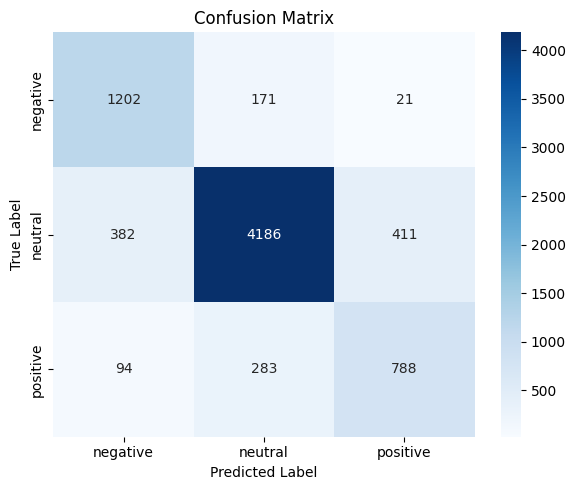

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(predictions.label_ids, preds)
labels = list(label2id.keys())

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

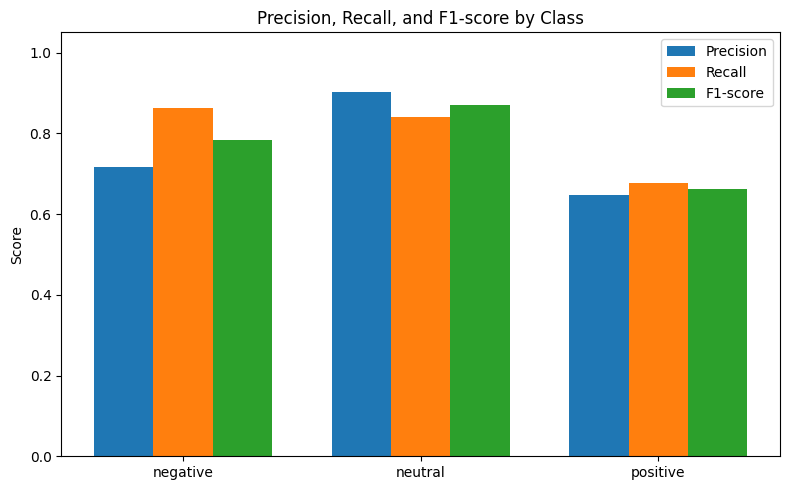

In [82]:
from sklearn.metrics import precision_recall_fscore_support

# Get class-wise metrics
precision, recall, f1, _ = precision_recall_fscore_support(predictions.label_ids, preds, labels=list(label2id.values()))
metrics = {'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Plotting
x = np.arange(len(label2id))  # positions for bars
width = 0.25  # width of bars

fig, ax = plt.subplots(figsize=(8, 5))
for i, (metric_name, values) in enumerate(metrics.items()):
    ax.bar(x + i * width, values, width, label=metric_name)

ax.set_xticks(x + width)
ax.set_xticklabels(label2id.keys())
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Precision, Recall, and F1-score by Class")
ax.legend()
plt.tight_layout()
plt.show()

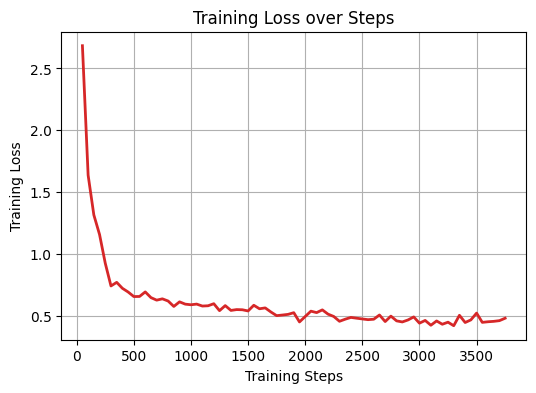

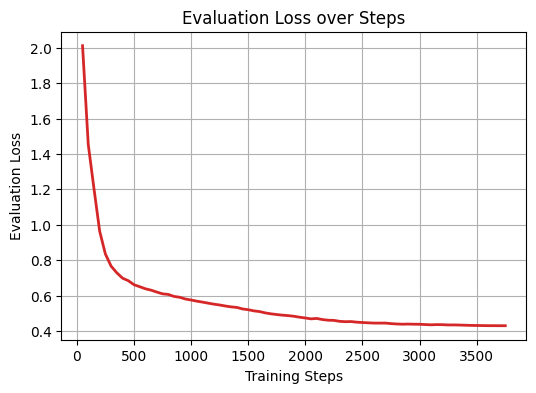

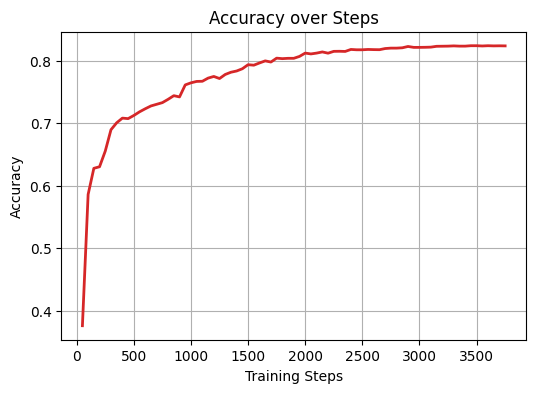

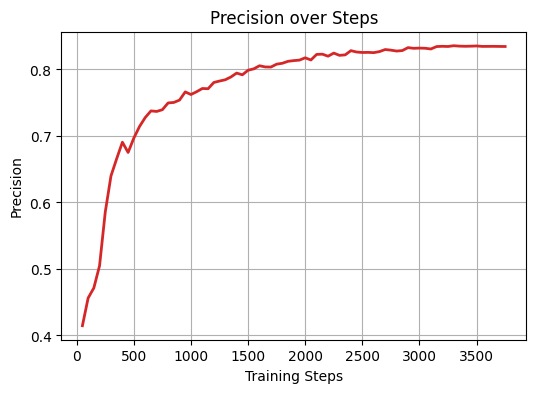

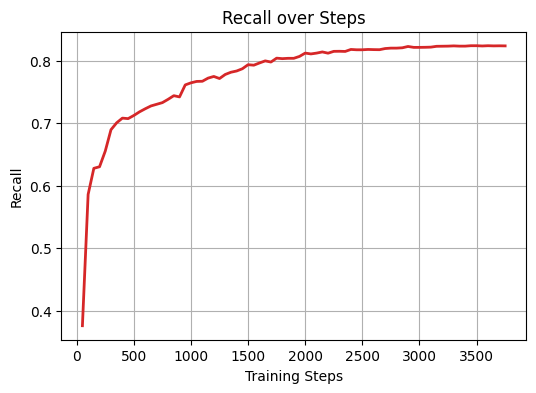

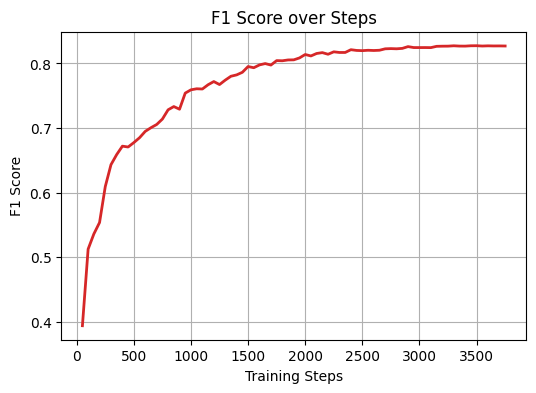

In [78]:
# Extract logs
logs = trainer.state.log_history

# Initialize dictionaries for metrics
train_loss, eval_loss = [], []
accuracy, precision, recall, f1 = [], [], [], []
steps = []

for log in logs:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        steps.append(log['step'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        accuracy.append(log['eval_accuracy'])
    if 'eval_precision' in log:
        precision.append(log['eval_precision'])
    if 'eval_recall' in log:
        recall.append(log['eval_recall'])
    if 'eval_f1' in log:
        f1.append(log['eval_f1'])

# Plot function
def plot_metric(metric_values, metric_name):
    plt.figure(figsize=(6, 4))
    plt.plot(steps[:len(metric_values)], metric_values, linestyle='-', linewidth=2, markersize=5, color='tab:red')
    plt.title(f"{metric_name} over Steps")
    plt.xlabel("Training Steps")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

# Plot each metric
plot_metric(train_loss, "Training Loss")
plot_metric(eval_loss, "Evaluation Loss")
plot_metric(accuracy, "Accuracy")
plot_metric(precision, "Precision")
plot_metric(recall, "Recall")
plot_metric(f1, "F1 Score")

### Step 3: Display relabled-to-neutral articles

This step helps investigating what articles are `relabled as neutral`.

In [95]:
id2label = {v: k for k, v in label2id.items()}
predicted_labels = [id2label[p] for p in preds]


test = test_dataset.to_pandas()
test['predicted_label'] = predicted_labels

# Step 4: Merge test with all_features (keeping only test rows)
# Assuming both test and all_features have a common key, e.g. 'id'
merged = test.merge(all_features, on='article', how='left')  # Replace 'id' with your actual join key

test

,article,agreement_label,predicted_label
0,"Fintel reports that on July 19, 2023, Stifel m...",neutral,neutral
1,Technology stocks were edging higher Wednesday...,positive,positive
2,"""This earnings season is turning out to be not...",negative,negative
3,A month has gone by since the last earnings re...,neutral,positive
4,Legendary investor Warren Buffett advises to b...,neutral,neutral
...,...,...,...
7533,Aegon NV ( AEK ) will begin trading ex-dividen...,neutral,neutral
7534,"In early trading on Monday, shares of Charter ...",positive,positive
7535,(0:45) - Stock Guru Stock Screening : Investin...,neutral,neutral
7536,Looking at the underlying holdings of the ETFs...,neutral,neutral


In [92]:
filtered_test = test[((test['agreement_label'] == 'positive') | (test['agreement_label'] == 'negative')) & (test['predicted_label'] == 'neutral')]
print(filtered_test['article'])

22      Followers of the movie industry know that in H...
38      Myriad Genetics, Inc. ( MYGN ) reported result...
48      Reneo Pharmaceuticals RPHM, a clinical-stage c...
53      Development-stage integrated lithium company P...
58      Nerdy (NYSE: NRDY) disappointed a lot of inves...
                              ...                        
7435    In this video, I will talk about what might ha...
7455    Wall Street has concluded the worst first half...
7491    Nike Inc (NKE) just released their second quar...
7521    You may have seen your utility bills rise rece...
7526    For the longest time, marijuana stocks were vi...
Name: article, Length: 454, dtype: object


In [93]:
filtered_test.to_csv("positive to neutral.csv", index=False)